In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import os
os.getcwd()

'/content'

In [3]:
from google.colab import files
uploaded = files.upload()

Saving DogCat.zip to DogCat.zip


In [4]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['DogCat.zip']), 'r')
data.extractall()

In [5]:
path = 'Try'
labels = [item for item in os.listdir(path) if os.path.isdir(os.path.join(path, item))]
labels

['Dog', 'Cat']

In [6]:
import cv2
import numpy as np
img_size = 100
training_data = []
label_data = []

for idx, label in enumerate(labels):
  temp = next(os.walk(path+'/'+label))[2]
  
  for img in temp:
    try:
      im = cv2.imread(path+'/'+label+'/'+img)
      # print(im.shape)
      im = cv2.resize(im,(img_size, img_size))
      im = np.array(im)
      training_data.append([im, idx])
      label_data.append([idx,label])
    except Exception as e:
        print(e)

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [7]:
training_data[0][0].shape

(100, 100, 3)

In [8]:
import pandas as pd
label_data = pd.DataFrame(label_data)
label_data = label_data[0].unique()
import random
random.shuffle(training_data)
X = []
Y = []
for features,label in training_data:
    X.append(features)
    Y.append(label)
X = np.array(X).reshape(-1, img_size, img_size,3)
X=X.astype('float32')
X=X/255.0

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
import tensorflow as tf


#Build the CNN model
model=Sequential()
model.add(Conv2D(32,(3,3), strides=1,input_shape=[img_size, img_size, 3], activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(64,(2,2),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(img_size,(2,2),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(300,activation='relu',kernel_constraint=maxnorm(3)))
model.add(Dropout(0.4))

model.add(Dense(300,activation='relu',kernel_constraint=maxnorm(3)))

model.add(Dense(100,activation='relu',kernel_constraint=maxnorm(3)))
model.add(Dense(len(label_data), activation='sigmoid'))
#________________________________________________________#


#Set the parameters of the CNN model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


#Reshape the features and labels to fit into the CNN model
# X = np.asarray(X).astype('float32').reshape((-1,img_size,img_size,1))
Y = np.asarray(Y).astype('float32').reshape((-1,1))


#Store the best model in a file
file_path= "model3.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=file_path,
                                                           monitor='val_accuracy',
                                                           mode='max',
                                                           save_best_only=True)



#Start the model training
history = model.fit(X, Y, epochs=20, callbacks=[model_checkpoint_callback],verbose=2, validation_split=0.2)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 100)       2

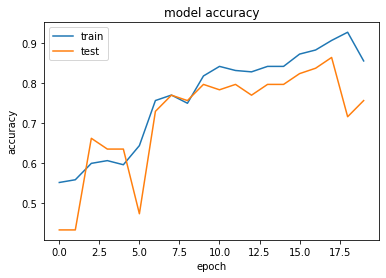

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
def test():
  idx = np.random.randint(1,len(X))
  test_img = X[idx:idx+1]
  pred = np.argmax(model.predict(test_img), axis=-1)[0]
  if pred ==1: 
    print("Ypur picture contains a Cat") 
  else:
     print("Your picture contains a Dog")
  plt.imshow(test_img[0])

Your picture contains a Dog


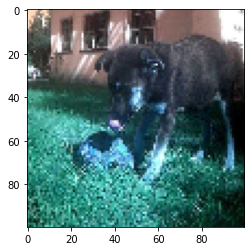

In [16]:
test()